# Unconstrained Salient Object Detection via Proposal Subset Optimization

Implementation of the paper:

    Jianming Zhang, Stan Sclaroff, Zhe Lin, Xiaohui Shen,
    Brian Price and Radomír Mech. "Unconstrained Salient
    Object Detection via Proposal Subset Optimization."
    CVPR, 2016.

Code written by Guillaume Balezo

Links:
- https://github.com/GuillaumeBalezo/SOD-python

You need to donwload:
- the CNN weights: https://drive.google.com/open?id=1YJ82f34inEwJXGQtZYRtgw1Sxd7KVsSi

## Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
%%capture
!unzip drive/My\ Drive/Meero/layout_aware_subnet/MSO.zip -d ./
!mkdir dataset
!mkdir dataset/MSO
!mv img/ dataset/MSO/

In [0]:
%tensorflow_version 2.x

## Paths

In [0]:
weights_path = 'TO COMPLETE' # path of sod_cnn_weights.h5
center_path = 'TO COMPLETE' # path of the center100.npy

## Imports

In [0]:
import numpy as np
from scipy import cluster
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import pickle
import glob2
from tqdm import tqdm_notebook as tqdm
import cv2
import time
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img

TensorFlow 2.x selected.


In [0]:
from google.colab.patches import cv2_imshow

## Saliency Object Detection (SOD) Model definition

## Usefull

In [0]:
def getParam(modelName, weights_path, center_path):
  param = {}
  param['modelName'] = modelName
  # See the paper for the meaning of the following three parameters
  param['lambda'] = 0.075
  param['gamma'] = 1
  param['phi'] = np.log(0.3)
  # The maximum output number
  param['maxnum'] = 30
  # By default, we perturb the initialization of our optimization for better
  # local maxima
  param['perturb'] = True
  # The number of proposals used from the whole image
  param['masterImgPropN'] = 30
  # The number of proposals used from each sub-image
  param['subImgPropN'] = 10
  # The number of sub-images (rois)
  param['roiN'] = 5
  # This parameter is used for merging similar rois
  param['roiClusterCutoff'] = 0.3
  param['roiExpand'] = 1
  # 100 proposal centers
  param['center'] = np.load(center_path)
  # The following parameters are for the CNN model
  param['weightsFile'] = weights_path
  param['useGPU'] = True
  param['GPUID'] = 0
  param['width'] = 224
  param['height'] = 224
  param['batchSize'] = 8

  return param

In [0]:
##############################################
# Utils functions
#
# Code converted by Guillaume Balezo from https://github.com/jimmie33/SOD
#
# Jianming Zhang, Stan Sclaroff, Zhe Lin, Xiaohui Shen, 
# Brian Price and Radomír Mech. "Unconstrained Salient 
# Object Detection via Proposal Subset Optimization." 
# CVPR, 2016.
##############################################

def getIOUFloat(res, gt):
  xmin = np.maximum(res[:, 0], gt[0])
  ymin = np.maximum(res[:, 1], gt[1])
  xmax = np.minimum(res[:, 2], gt[2])
  ymax = np.minimum(res[:, 3], gt[3])
  I = np.maximum(xmax - xmin, 0) * np.maximum(ymax - ymin, 0)
  U = (res[:, 2] - res[:, 0]) * (res[:, 3] - res[:, 1]) + (gt[2] - gt[0]) * (gt[3] - gt[1])
  iou = I / (U - I)
  if iou.size == 1:
    iou = iou.item()
  return iou

def getROIBBox(B, ROI):
  # Translate the coordinates back into the original image.
  ratio = ROI[2:] - ROI[:2]
  B = B * np.tile(ratio, 2).reshape(-1, 1)
  B = B + np.tile(ROI[:2], 2).reshape(-1, 1)
  return B

def expandROI(roi, imsz, margin):
  roi[: 2, :] = roi[: 2, :] - margin
  roi[2 :, :] = roi[2 :, :] + margin
  roi[: 2, :] = np.maximum(roi[: 2, :], 0)
  roi[2, :] = np.minimum(roi[2, :], imsz[1])
  roi[3, :] = np.minimum(roi[3, :], imsz[0])
  return roi

def getIOU(res, gt):
  xmin = np.maximum(res[:, 0], gt[0])
  ymin = np.maximum(res[:, 1], gt[1])
  xmax = np.minimum(res[:, 2], gt[2])
  ymax = np.minimum(res[:, 3], gt[3])

  I = np.maximum((xmax - xmin + 1),0) * np.maximum((ymax - ymin + 1), 0)
  U = (res[:, 2] - res[:, 0] + 1) * (res[:, 3] - res[:, 1] + 1) + (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
  iou = I / (U - I)
  return iou

def getMaxIncFloat(res, gt):
  #############################################
  # Another way to define window similarity:
  # Intersection over min area.
  #############################################
  xmin = np.maximum(res[:, 0], gt[0])
  ymin = np.maximum(res[:, 1], gt[1])
  xmax = np.minimum(res[:, 2], gt[2])
  ymax = np.minimum(res[:, 3], gt[3])
  I = np.maximum((xmax - xmin), 0) * np.maximum((ymax - ymin), 0)
  U1 = (res[:, 2] - res[:, 0]) * (res[:, 3] - res[:, 1])
  U2 = (gt[2] - gt[0]) * (gt[3] - gt[1])
  inc = I / np.minimum(U1, U2)
  return inc

def doNMS(bboxes, thresh):
  if bboxes.size == 0: #not sure
    return bboxes, None

  tmp = bboxes[:, 0].reshape(-1, 1)
  idx = 0
  for i in range(1, bboxes.shape[1]):
    #if tmp.shape[0] > 1:
    bboxes_i = bboxes[:, i].reshape(4, -1)
    iou = np.array(getIOUFloat(tmp.T, bboxes_i))
    if (iou < thresh).all():
      tmp = np.hstack((tmp, bboxes_i))
      idx = np.hstack((idx, i))
    #else:
      #if np.maximum(getIOUFloat(tmp[:, None].T, bboxes[:, i])) < thresh:
        #tmp = np.hstack((tmp, bboxes[:, i]))
        #idx = np.hstack((idx,i))

  bboxes = np.copy(tmp)
  return bboxes, idx

def doMMR(bbox, score, lambda_):
  #############################################
  # An implementation of the Maximum Marginal
  # Relevance re-ranking method used in this
  # paper:
      # J. Carreira and C. Sminchisescu. CPMC:
      # Automatic object segmentation using
      # constrained parametric min-cuts. PAMI,
      # 34(7):1312–1328, 2012.
  #############################################
  bbox = np.hstack((bbox, score.reshape(-1, 1)))
  if bbox.size == 0:
    return P, S

  res = bbox[0].reshape(1, -1)
  bbox = np.delete(bbox, 0, axis = 0)
  while bbox.size != 0:
    
    ss = bbox[:, -1]
    for i in range(bbox.shape[0]):
      ss[i] = ss[i] - lambda_ * getIOU(res, bbox[i, :4]).max(0) #######
    iidx = np.argsort(-ss, axis = 0)
    ss = ss[iidx]
    bbox = bbox[iidx, :]
    res = np.append(res, np.hstack((bbox[0, :4], ss[0])).reshape(1, -1), axis = 0)
    bbox = np.delete(bbox, 0, axis = 0)


  P = res[:, :4].T ########
  S = res[:, -1]
  return P, S

def imreadRGB(fileNames):
  ##############################################
  # Handles index images and grayscale images
  ##############################################
  I_batch = []
  for i in range(len(fileNames)):
    I_batch.append(np.array(load_img(fileNames[i])))
  return I_batch

def display_preds(fn, res, color = (255, 0, 0)):
  img = cv2.imread(fn)
  for i in range(res.shape[1]):
    rect = res[:, i].astype(int)
    img = cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), color, thickness = 5)
  cv2_imshow(img)

In [0]:
##############################################
# Functions for generating the proposal set for optimization
#
# Code converted by Guillaume Balezo from https://github.com/jimmie33/SOD
#
# Jianming Zhang, Stan Sclaroff, Zhe Lin, Xiaohui Shen, 
# Brian Price and Radomír Mech. "Unconstrained Salient 
# Object Detection via Proposal Subset Optimization." 
# CVPR, 2016.
##############################################

def getProposals(I_batch, net, param):
  ##############################################
  # Generate the proposal set for optimization
  ##############################################
  Ip = prepareImage(I_batch, param)
  scores_batch = net.predict(Ip)
  P_batch = []
  S_batch = []
  for idx_batch in range(len(I_batch)):
    scores = scores_batch[idx_batch]
    I = I_batch[idx_batch] ##########
    imsz = np.array([I.shape[0], I.shape[1]])
    top_idxs = np.argsort(-scores)
    scores = np.take(scores, top_idxs)
    BB = param['center'][:, top_idxs]
    P = BB[:, : param['masterImgPropN']].copy()
    S = scores[: param['masterImgPropN']].copy()
    # extract ROIs
    ROI = BB[:, : param['roiN']].copy()
    ROI = postProc(ROI, imsz, param)
    ROI = clusterBoxes(ROI, param) # merge some ROI if needed
    # process ROIs
    Ip = cropImgList_and_Prepare(I.copy(), ROI, param)
    if Ip.size == 0:
      P_batch.append(P)
      S_batch.append(S)
      continue
    scores = net.predict(Ip)
    top_idxs = np.argsort(-scores, axis = 1)
    scores = np.take_along_axis(scores, top_idxs, axis = 1)
    for i in range(Ip.shape[0]):
      B = param['center'][:, top_idxs[i, : param['subImgPropN']]]
      roi = ROI[:, i] / np.tile(np.roll(imsz, 1), 2)
      B = getROIBBox(B.copy(), roi)
      P = np.hstack((P, B))
      S = np.hstack((S, scores[i, : param['subImgPropN']]))
    P_batch.append(P)
    S_batch.append(S)
  return P_batch, S_batch


def prepareImage(I_batch, param):
  Ip = np.zeros((len(I_batch), param['width'], param['height'], 3))
  for i in range(len(I_batch)):
    img = I_batch[i]
    img = preprocess_input(img, mode='caffe')
    Ip[i] = np.expand_dims(cv2.resize(img, (param['width'], param['height']), interpolation = cv2.INTER_LINEAR), axis = 0)
  return Ip

def clusterBoxes(BB, param):
  if BB.shape[1] < 2:
    ROI = np.copy(BB)
    return ROI
  
  D = []
  for i in range(BB.shape[1]):
    for j in range(i + 1, BB.shape[1]):
      D.append(1 - getIOUFloat(BB[:, j].reshape(-1, 1).T, BB[:, i]))
  Z = cluster.hierarchy.linkage(D)
  T = cluster.hierarchy.fcluster(Z, param['roiClusterCutoff'], criterion = 'distance')
  ROI = np.vstack((BB[:2, T == 1].min(axis = 1, keepdims=True), BB[2:, T == 1].max(axis = 1, keepdims=True))) # initialisation for the for loop
  for i in range(2, T.max() + 1):
    ROI = np.hstack((ROI, np.vstack((BB[:2, T == i].min(axis = 1, keepdims=True), BB[2:, T == i].max(axis = 1, keepdims=True)))))
  return ROI

def postProc(ROI, imsz, param):
  # expand
  w = ROI[2] - ROI[0]
  h = ROI[3] - ROI[1]
  ROI[0] = ROI[0] - 0.5 * w * param['roiExpand']
  ROI[1] = ROI[1] - 0.5 * h * param['roiExpand']
  ROI[2] = ROI[0] + w * (1 + param['roiExpand'])
  ROI[3] = ROI[1] + h * (1 + param['roiExpand'])

  ROI = ROI * np.tile(np.roll(imsz, 1), 2).reshape(-1, 1)
  ROI[:2] = np.maximum(ROI[:2], 0)
  ROI[2] = np.minimum(ROI[2], imsz[1])
  ROI[3] = np.minimum(ROI[3], imsz[0])


  # removing
  area = (ROI[2] - ROI[0] + 1) * (ROI[3] - ROI[1] + 1)

  ROI = ROI[:, area < (0.9 * imsz[0] * imsz[1])]
  return ROI


def cropImgList_and_Prepare(img, roilist, param):
  Ip = []
  if len(roilist.shape) == 1:
    roilist = roilist.reshape(-1, 1)
  for i in range(roilist.shape[1]):
    roi = roilist[:, i]
    img_cropped = img[int(roi[1]) : int(roi[3]) + 1, int(roi[0]) : int(roi[2]) + 1, :]
    img_cropped = preprocess_input(img_cropped, mode = 'caffe')
    Ip.append(cv2.resize(img_cropped, (param['height'], param['width']), interpolation = cv2.INTER_LINEAR))
  return np.array(Ip)

In [0]:
##############################################
# Subset optimization functions
#
# Code converted by Guillaume Balezo from https://github.com/jimmie33/SOD
#
# Jianming Zhang, Stan Sclaroff, Zhe Lin, Xiaohui Shen, 
# Brian Price and Radomír Mech. "Unconstrained Salient 
# Object Detection via Proposal Subset Optimization." 
# CVPR, 2016.
##############################################


def propOpt(bboxes, bboxscore, param):
  ##################################################
  # The main function for the subset optimization
  ##################################################


  # for the special case when lambda == 0
  if param['lambda'] == 0:
    stat = {}
    res = bboxes.copy()
    stat['O'] = np.arange(bboxes.shape[1]).reshape(-1, 1)
    return res, stat

  stat = doMAPForward(bboxes, bboxscore.astype(float), param)
  if stat['O'].size > 1:
    stat = doMAPBackward(bboxes, bboxscore.astype(float), param, stat)

  # We use the second output to intialized the optimization again
  if param['perturb'] and len(stat['O']) > 1:
    # use the second output to initialize the forward pass
    statTmp = doMAPEval(bboxes, bboxscore.astype(float), param, stat['O'][1], stat['W'], stat['BGp'])
    statTmp = doMAPForward(bboxes, bboxscore.astype(float), param, statTmp)
    if statTmp['f'] > stat['f']:
      stat = statTmp.copy()
  res = np.take(bboxes, stat['O'].flatten(), axis = 1).copy()
  return res, stat


def doMAPForward(B, S, param, stat = None):
  if B.size == 0:
    print('Empty proposal set')
    stat = {}
    return stat
  
  nB = B.shape[1]
  if not stat:
    # initialization
    stat = {}
    stat['W'] = np.array([])
    stat['Xp'] = np.array([])
    stat['X'] = np.zeros((nB, 1))
    # construct W
    stat['W'], stat['Xp'] = getW(B, S, param)
    stat['BGp'] = stat['Xp'].copy()
    stat['nms'] = np.zeros((B.shape[1], 1))
    stat['f'] = stat['Xp'].sum()
    stat['O'] = np.array([], dtype=int)

    ## loop
    while len(stat['O']) < min(param['maxnum'], nB):
      V = np.maximum(stat['W'] - stat['Xp'].reshape(-1, 1), 0)
      #V = np.maximum(stat['W'] - np.tile(stat['Xp'], (1,nB)), 0)
      scores = V.sum(axis = 0) + stat['nms'].flatten().T
      vote = np.argmax(scores)
      score = scores[vote]
      if score == 0:
        break
      tmpf = stat['f'] + score + param['phi']

      if (tmpf > stat['f']):
        mask = V[:, vote] > 0
        stat['X'][mask] = vote
        stat['O'] = np.append(stat['O'], vote).reshape(-1, 1)
        stat['Xp'][mask] = stat['W'][mask, vote]
        stat['f'] = tmpf
        stat['nms'] = stat['nms'] + param['gamma'] * getNMSPenalty(B, B[:, vote]).reshape(-1, 1)
      else:
        break
  return stat

def doMAPBackward(B, S, param, stat):
  while stat['O'].size != 0:
    flag = False
    bestStat = stat.copy()
    for i in range(len(stat['O'])):
      O = stat['O'].copy()
      O = np.delete(O, i)
      statTmp = doMAPEval(B, S, param, O, stat['W'], stat['BGp'])
      if statTmp['f'] > bestStat['f']:
        flag = True
        bestStat = statTmp.copy()
    stat = bestStat.copy()
    if not flag:
      break

  return stat

def doMAPEval(B, S, param, O, W = None, BGp = None):
  ##############################################
  # This function evaluate the target function
  # given a output window set.
  ##############################################
  statTmp = {}
  statTmp['W'] = np.array([])
  statTmp['Xp'] = np.array([])

  statTmp['X'] = np.zeros((B.shape[1], 1))
  if type(W).__name__ == 'NoneType' or type(BGp).__name__ == 'NoneType': ###better
    # construct W
    statTmp['W'], statTmp['BGp'] = getW(B, S, param)
  else:
    statTmp['W'] = W.copy()
    statTmp['BGp'] = BGp.copy()

  statTmp['nms'] = np.zeros((B.shape[1],1))
  statTmp['O'] = O.copy()
  statTmp['f'] = O.size * param['phi']
  for i in range(O.size):
    statTmp['f'] = statTmp['f'] + statTmp['nms'][O[i], 0]
    statTmp['nms'] = statTmp['nms'] + param['gamma'] * getNMSPenalty(B, B[:, O[i]]).reshape(-1, 1)
  
  if O.size == 0:
    statTmp['f'] = statTmp['f'] + np.sum(BGp)
    return statTmp

  tmp_val = statTmp['W'][:, O]
  ass = tmp_val.argmax(axis = 1)
  Xp = tmp_val.max(axis = 1, keepdims=True)
  mask = Xp > BGp.reshape(BGp.shape[0], -1)
  statTmp['X'][mask] = ass.reshape(-1, 1)[mask]
  statTmp['Xp'] = np.maximum(Xp, BGp)
  statTmp['f'] = statTmp['f'] + statTmp['Xp'].sum()
  return statTmp

def getNMSPenalty(B, b):
  p = -0.5 * (getMaxIncFloat(B.T, b) + getIOUFloat(B.T, b))
  return p

def getW(B, S, param):
  #######################################################
  # Precompute all w_{ij}
  # Xp is the likelihood of the optimal assignments given
  # the current output set
  #######################################################
  P = np.zeros((B.shape[1], B.shape[1]))
  for i in range(B.shape[1]):
    P[i, :] = getIOUFloat(B.T, B[:, i].T)
  P = P * S.reshape(-1, 1)
  P = np.hstack((P, param['lambda'] * np.ones((B.shape[1], 1))))
  np.seterr(divide='ignore')
  P = P / P.sum(axis = 1, keepdims=True)
  W = np.log(P)
  Xp = W[:, -1]
  W = W[:, : -1]
  return W, Xp

def refineWin(I, res, net, param):
  ########################################################
  # A heuristic way to further refine the output windows
  
  # For each small output window, we run our method on the
  # this ROI again and extract the output that has the
  # largest IOU with the orignal window for replacement.
  
  # NMS is further applied to remove duplicate windows.
  ########################################################
  imsz = np.array([I.shape[0], I.shape[1]])
  param['lambda'] = 0.05
  for i in range(res.shape[1]):
    bb = res[:, i].reshape(4, -1)
    bbArea = (bb[2, 0] - bb[0, 0]) * (bb[3, 0] - bb[1, 0])
    # only refine small windows
    if bbArea < (0.125 * imsz[0] * imsz[1]):
      margin = (bb[2] - bb[0] + bb[3] - bb[1]) * 0.2
      bb = expandROI(bb, imsz, margin).astype(int)[:, 0]
      Itmp = I[bb[1] : bb[3], bb[0] : bb[2], :]
      Ptmp, Stmp = getProposals(Itmp, net, param)
      restmp, _ = propOpt(Ptmp, Stmp, param)

      if restmp.size != 0:
        restmp = getROIBBox(restmp, bb)
        ii = np.array(getIOUFloat(restmp.T, res[:, i])).argmax()
        res[:, i] = restmp[:, ii]

  res = doNMS(res, 0.5)
  return res

In [0]:
##############################################
# Evaluation functions on the MSO dataset
#
# Code converted by Guillaume Balezo from https://github.com/jimmie33/SOD
#
# Jianming Zhang, Stan Sclaroff, Zhe Lin, Xiaohui Shen, 
# Brian Price and Radomír Mech. "Unconstrained Salient 
# Object Detection via Proposal Subset Optimization." 
# CVPR, 2016.
##############################################


def calcAP(rec, prec, interval = None):
  ##############################################
  # Calculating average precision using 11 point
  # averaging.

  # We first linearly interpolate the PR curves,
  # which turns out to be more robust to the
  # number of points sampled on the PR cureve.
  ##############################################
  if not interval:
    interval = np.arange(0,1,0.1)

  # linear interpolation
  ii = np.argsort(rec) # axis ?
  rec = np.take(rec, ii)
  prec = np.take(prec, ii)
  rec, ii = np.unique(rec, return_index = True)
  prec = np.take(prec, ii)
  Rq = np.arange(0, 1, 0.01)
  Pq = np.interp(Rq, rec, prec)
  Pq = np.nan_to_num(Pq, nan = 0)
  prec = np.copy(Pq)
  rec = np.copy(Rq)
  ap = 0
  for t in interval:
    p = prec[rec >= t].max(0)
    if p.size == 0:
      p = 0
    ap = ap + p / len(interval)
  return ap

def evaluateBBox(imgList, res):
  ##############################################
  # Function for evaluation.

  # It outputs the number of hits, prediction
  # and ground truths for each image.
  ##############################################
  TTP = np.zeros((len(res), len(imgList)))
  NPred = np.zeros((len(res), len(imgList)))
  NGT = np.zeros(len(imgList))
  for i in range(len(res)):
    pred_num = np.zeros(len(imgList))
    TP = np.zeros(len(imgList))
    for j in range(len(imgList)):
      anno = imgList[j]['anno']
      if len(anno.shape) == 2:
        NGT[j] = anno.shape[1]
      else:
        NGT[j] = 0
      pred_num[j] = res[i][j].shape[1]
      bboxes = getGTHitBoxes(res[i][j], anno, 0.5).reshape(4, -1)
      if bboxes.size == 0:
        TP[j] = 0
      else:
        TP[j] = bboxes.shape[1]
    TTP[i, :] = TP
    NPred[i, :] = pred_num

  TP = np.copy(TTP)
  return TP, NPred, NGT

def getGTHitBoxes(bboxes, anno, thresh):
  ##############################################
  # This function returns the correct detection
  # windows given the ground truth.
  ##############################################
  res = np.array([])
  if anno.size == 0 or bboxes.size == 0:
    return res
  for i in range(anno.shape[1]):
    iou = getIOU(bboxes.T, anno[:, i])
    idx = iou.argmax()
    score = iou[idx]
    if score > thresh:
      res = np.concatenate((res, bboxes[:, idx]))
      bboxes = np.delete(bboxes, idx, axis = 1)
      if bboxes.size == 0:
        break
  return res

def read_props(filename):
  return pickle.load(open(filename, "rb" ))

def save_props(props, filename):
  pickle.dump(props, open( filename, "wb" ))

def load_MSO_dataset(filepath = 'imgIdx.mat'):
  with h5py.File(filepath, 'r') as f:
    ref_names = np.array(f['imgIdx']['name'])
    ref_annos = np.array(f['imgIdx']['anno'])
    nb_images = ref_names.shape[0]
    imgIdx = []
    for i in range(nb_images):
      imgIdx.append({})
      name_encoded = np.array(f[ref_names[i, 0]])
      name = ''
      for code in name_encoded:
        name += chr(code[0])
      imgIdx[i]['name'] = name
      anno = np.array(f[ref_annos[i, 0]])
      if anno.size == 2:
        anno = np.array([])
      imgIdx[i]['anno'] = anno
  return imgIdx

In [0]:
def initModel(param):
  '''
  Input:
      weights_path: path of h5 file with the weights
      center_path: path of npy file with the center bounding boxes
  Output:
      model: SOD cnn model
  '''
  vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=(224, 224, 3))
  flat = tf.keras.layers.Flatten()(vgg16.output)
  fc6 = tf.keras.layers.Dense(4096, activation='relu')(flat)
  fc7 = tf.keras.layers.Dense(4096, activation='relu')(fc6)
  fc8 = tf.keras.layers.Dense(100, activation='sigmoid')(fc7)
  model = tf.keras.models.Model(inputs=[vgg16.input], outputs=[fc8])
  model.load_weights(param['weightsFile'])
  model.trainable = False
  return model

In [0]:
class SOD:

  def __init__(self, modelName = 'SOD_python', weights_path = weights_path, center_path = center_path):
    self.param = getParam(modelName, weights_path, center_path)
    K.clear_session()
    self.net = initModel(self.param)
  
  def split_batch(self, fns):
    m = len(fns)
    batches = []
    for i in range(0, m, self.param['batchSize']):
      batches.append(fns[i: i + self.param['batchSize']])
    if i + 10 < m:
      batches.append(fns[i:])
    return batches
    
  def predict(self, fns, refine = False, verbose = False):

    start = time.time()
    batches = self.split_batch(fns)
    res_all = []
    for batch in tqdm(batches):
      I_batch = imreadRGB(batch)
      P_batch, S_batch = getProposals(I_batch, self.net, self.param)
      res_batch = []
      for idx_batch, (P, S) in enumerate(zip(P_batch, S_batch)):
        I = I_batch[idx_batch]
        imsz = [I.shape[0], I.shape[1]]
        res, _ = propOpt(P, S, self.param)
        # scale bboxes to full size
        res = res * np.tile(np.roll(imsz, 1), 2).reshape(-1, 1)

        # optional window refining process
        if refine:
          I = np.expand_dims(I, axis = 0)
          res, _ = refineWin(I, res, self.net, self.param)
        
        res = res.astype(int)
        res_batch.append(res)

      res_all.extend(res_batch)

    if verbose:
      print('Time elapsed: {}'.format(round(time.time() - start, 2)))
      print('Time per images: {}'.format(round((time.time() - start)/len(fns), 2)))
    return res_all

  def predict_for_benchmark(self, fns):
    batches = self.split_batch(fns)
    P_all = []
    S_all = []
    for batch in tqdm(batches):
      I_batch = imreadRGB(batch)
      P_batch, S_batch = getProposals(I_batch, self.net, self.param)
      P_all.extend(P_batch)
      S_all.extend(S_batch)
    return P_all, S_all

sod_model = SOD()

In [0]:
fns = glob2.glob('dataset/MSO/img/*.jpg')
res = sod_model.predict(fns, refine = True, verbose = True)


Time elapsed: 92.41
Time per images: 0.08


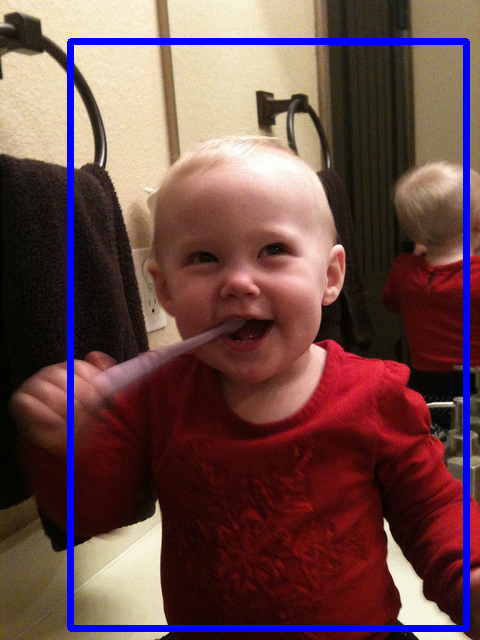

In [0]:
idx = 1000

display_preds(fns[idx], res[idx])


run the MAP method
processed 0 images
processed 100 images
processed 200 images
processed 300 images
processed 400 images
processed 500 images
processed 600 images
processed 700 images
processed 800 images
processed 900 images
processed 1000 images
processed 1100 images
processed 1200 images
run the NMS baseline
processed 0 images
processed 100 images
processed 200 images
processed 300 images
processed 400 images
processed 500 images
processed 600 images
processed 700 images
processed 800 images
processed 900 images
processed 1000 images
processed 1100 images
processed 1200 images
run the MMR  baseline
processed 0 images
processed 100 images
processed 200 images
processed 300 images
processed 400 images
processed 500 images
processed 600 images
processed 700 images
processed 800 images
processed 900 images
processed 1000 images
processed 1100 images
processed 1200 images


Text(0.5, 1.0, 'PR Curves on the MSO Dataset (SOD_python)')

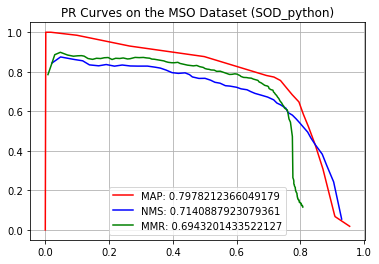

In [0]:
##############################################
# Benchmark methods on the MSO dataset
#
# Code converted by Guillaume Balezo from https://github.com/jimmie33/SOD
#
# Jianming Zhang, Stan Sclaroff, Zhe Lin, Xiaohui Shen, 
# Brian Price and Radomír Mech. "Unconstrained Salient 
# Object Detection via Proposal Subset Optimization." 
# CVPR, 2016.
##############################################

import os

param = getParam(modelName = 'SOD_python', weights_path = weights_path, center_path = center_path)
net = initModel(param)
sod_model = SOD()
imgIdx = load_MSO_dataset()

#cacheDir = 'propCache'
cacheDir = 'propCache'
if not os.path.isdir(cacheDir):
  os.mkdir(cacheDir)

props = []
flag = False


cacheName = 'MSO_' + param['modelName'] + '.pickle'

# load precomputed proposals if possible
if os.path.isfile(cacheDir + '/' + cacheName):
  print('using precomputed proposals')
  props = read_props(cacheDir + '/' + cacheName)
  flag = True
else:
  fns = ['dataset/MSO/img/' + imgIdx[i]['name'] for i in range(len(imgIdx))]
  P_all, S_all = sod_model.predict_for_benchmark(fns)


legs = []

## evaluate the MAP method
print('run the MAP method')
lambda_ = [0, 0.000001, 0.0001]
lambda_.extend(list(np.arange(0.01, 0.1, 0.01)))
lambda_.extend(list(np.arange(0.1, 1, 0.1)))
res = [[[] for j in range(len(imgIdx))] for i in range(len(lambda_))]
for j in range(len(imgIdx)):
  I = imreadRGB(['dataset/MSO/img/' + imgIdx[j]['name']])[0]
  imsz = np.array([I.shape[0], I.shape[1]])
  
  # load precomputed proposals
  if flag: 
    P = props[j]['P']
    S = props[j]['S']
  else:
    props.append({})
    P = P_all[j]
    S = S_all[j]
    props[j]['P'] = P
    props[j]['S'] = S

  if j % 100 == 0:
    print('processed {} images'.format(j))


  for i in range(len(lambda_)):
    param['lambda'] = lambda_[i]
    param['gamma'] = 10 * lambda_[i]
    tmpRes, _ = propOpt(P, S, param)
    
    # scale bboxes to full size
    tmpRes = tmpRes * np.tile(np.roll(imsz, 1), 2).reshape(-1, 1)
    res[i][j] = tmpRes


K.clear_session()

if not flag:
  save_props(props, cacheDir + '/' + cacheName)

plt.figure()
TP, NPred, NGT = evaluateBBox(imgIdx, res.copy())

P = TP.sum(1) / np.maximum(NPred.sum(1), 0.01)
R = TP.sum(1) / np.maximum(NGT.sum(), 0.01)
plt.plot(R, P, 'r')
ap = calcAP(R, P)
legs.append('MAP: {}'.format(ap))

## evaluate the NMS baseline
print('run the NMS baseline')
thresh = np.arange(0, 1, 0.02)
res = [[[] for j in range(len(imgIdx))] for i in range(len(thresh))]
for j in range(len(imgIdx)):
  I = imreadRGB(['dataset/MSO/img/' + imgIdx[j]['name']])[0]
  imsz = np.array([I.shape[0], I.shape[1]])
  P = props[j]['P']
  S = props[j]['S']
  if j % 100 == 0:
    print('processed {} images'.format(j))
            
  # scale bboxes to full size
  P = P * np.tile(np.roll(imsz, 1), 2).reshape(-1, 1)
  idx = np.argsort(-S)
  S = np.take(S, idx)
  P = np.take(P, idx, axis = 1)
  P, sidx = doNMS(P, 0.4)
  S = S[sidx]
    
  for i in range(len(thresh)):
    tmpRes = P[:, S >= thresh[i]]
    res[i][j] = tmpRes

TP, NPred, NGT = evaluateBBox(imgIdx, res)
P = TP.sum(1) / np.maximum(NPred.sum(1), 0.01)
R = TP.sum(1) / np.maximum(NGT.sum(), 0.01)
plt.plot(R, P, 'b')
ap = calcAP(R,P)
legs.append('NMS: {}'.format(ap))

## evaluate the MMR baseline
print('run the MMR  baseline')
thresh = np.arange(-1.0, 1.0, 0.01)
res = [[[] for j in range(len(imgIdx))] for i in range(len(thresh))]
for j in range(len(imgIdx)):
  I = imreadRGB(['dataset/MSO/img/' + imgIdx[j]['name']])[0]
  imsz = np.array([I.shape[0], I.shape[1]])
  P = props[j]['P']
  S = props[j]['S']
  if j % 100 == 0:
    print('processed {} images'.format(j))

            
  # scale bboxes to full size
  P = P * np.tile(np.roll(imsz, 1), 2).reshape(-1, 1)
  idx = np.argsort(-S)
  S = np.take(S, idx)
  P = np.take(P, idx, axis = 1)
  [P, S] = doMMR(P.T, S, 1.0)
  for i in range(len(thresh)):
    tmpRes = P[:, S > thresh[i]]
    res[i][j] = tmpRes

TP, NPred, NGT = evaluateBBox(imgIdx, res)
P = TP.sum(1) / np.maximum(NPred.sum(1), 0.01)
R = TP.sum(1) / np.maximum(NGT.sum(), 0.01)
plt.plot(R,P,'g')
ap = calcAP(R,P)
legs.append('MMR: {}'.format(ap))

plt.grid()
plt.legend(legs)
plt.title('PR Curves on the MSO Dataset ({})'.format(param['modelName']))

## Display preds

In [0]:
props = read_props(cacheDir + '/' + cacheName)
imgIdx = load_MSO_dataset()

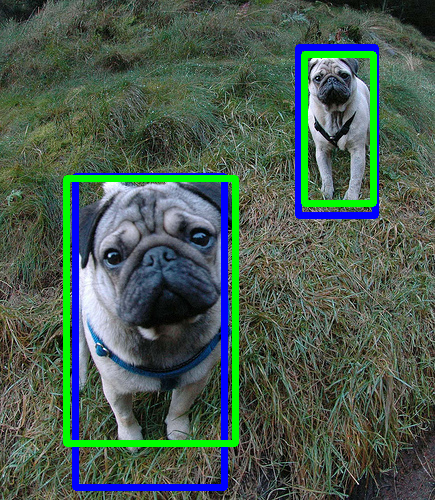

In [0]:
idx = 1006
fname = 'dataset/MSO/img/' + imgIdx[idx]['name']
img = cv2.imread(fname)
anno = imgIdx[idx]['anno']
res = sod_model.predict([fname])[0]

for i in range(res.shape[1]):
  rect = res[:, i].astype(int)
  img = cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (255, 0, 0), thickness = 5)

for i in range(anno.shape[1]):
  rect = anno[:, i].astype(int)
  img = cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), (0, 255, 0), thickness = 5)
cv2_imshow(img)